<a href="https://colab.research.google.com/github/HenrySomeCode/Transfer-learning-using-Various-Pretrained-Models-to-Predict-Fruits/blob/main/fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:
* https://www.kaggle.com/code/databeru/classify-15-fruits-with-tensorflow-acc-99-6/notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
# Load the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from IPython.display import Markdown, display

In [3]:
def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

In [4]:
printmd("a")

a

In [5]:
np.random.seed(0) # Add random seed of training for reproducibility

In [6]:
def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [7]:
core_path = "/content/drive/MyDrive/AI_ML_DL Course_by_Master_Linh_HUST/week6/fruit_classification"

In [8]:
!mkdir fruit-recognition

mkdir: cannot create directory ‘fruit-recognition’: File exists


In [9]:
zip_path = core_path+'/data/archive.zip'
!cp "{zip_path}" fruit-recognition
!unzip "fruit-recognition/archive.zip" -d "fruit-recognition"
!rm "fruit-recognition/archive.zip"

^C
Archive:  fruit-recognition/archive.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of fruit-recognition/archive.zip or
        fruit-recognition/archive.zip.zip, and cannot find fruit-recognition/archive.zip.ZIP, period.


In [7]:
# Load the paths on the images
images = []
dirp = "/content/fruit-recognition/"
for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else:
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)

# Create a dataframe with the paths and the label for each fruit
df = pd.DataFrame(images, columns = ["fruit", "path"])

# Shuffle the dataset
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Assign to each fruit a specific number

fruit_names = sorted(df.fruit.unique())
print(fruit_names)
mapper_fruit_names = dict(
    zip(fruit_names,
        [t for t in range(len(fruit_names))]
        )
    )
print(mapper_fruit_names)
df["label"] = df["fruit"].map(mapper_fruit_names)
# Visualize the resulting dataframe
df.head()

['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'muskmelon']
{'Apple': 0, 'Banana': 1, 'Carambola': 2, 'Guava': 3, 'Kiwi': 4, 'Mango': 5, 'Orange': 6, 'Peach': 7, 'Pear': 8, 'Persimmon': 9, 'Pitaya': 10, 'Plum': 11, 'Pomegranate': 12, 'Tomatoes': 13, 'muskmelon': 14}


fruit                                               path  label
0   Kiwi  /content/fruit-recognition/Kiwi/kiwi A/Kiwi A0...      4
1   Kiwi  /content/fruit-recognition/Kiwi/kiwi A/Kiwi A0...      4
2  Guava  /content/fruit-recognition/Guava/guava total f...      3
3   Pear      /content/fruit-recognition/Pear/Pear 1770.png      8
4  Apple  /content/fruit-recognition/Apple/Apple A/Apple...      0

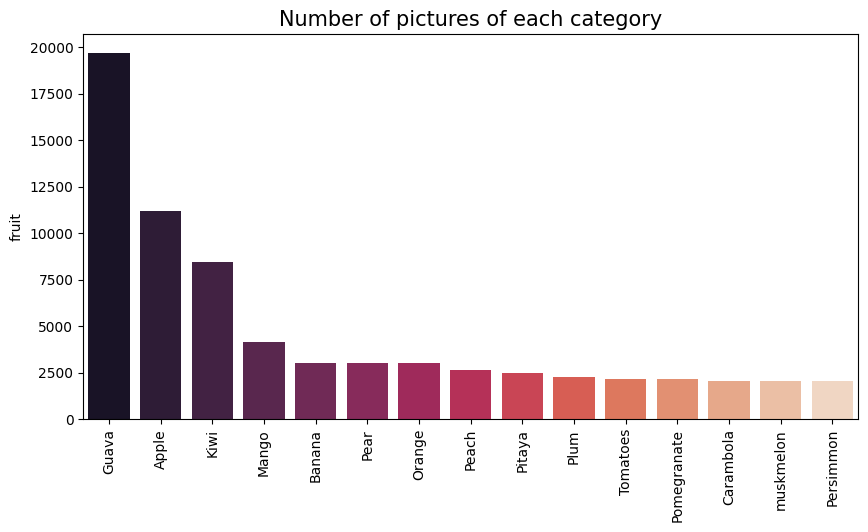

In [8]:
# Display the number of pictures of each category
vc = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

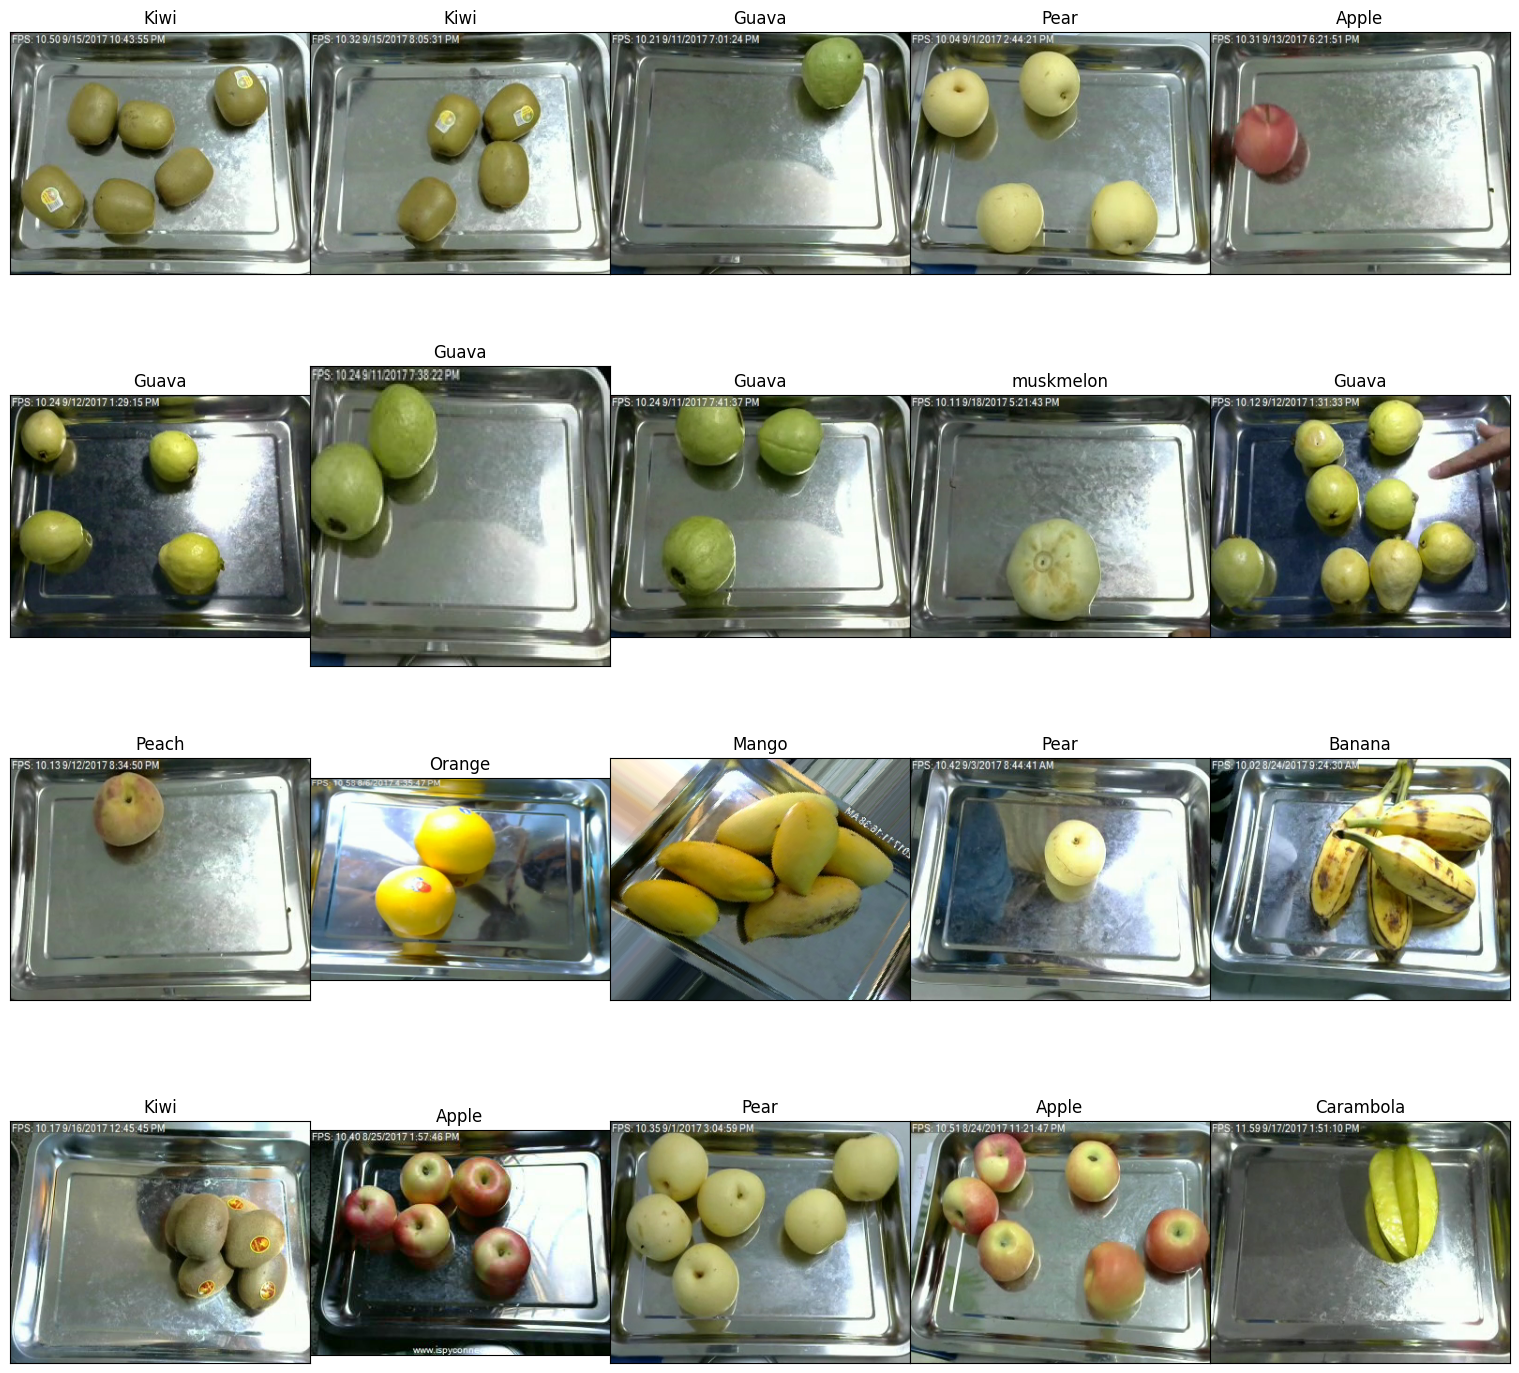

In [9]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

In [10]:
def create_model():
    shape_img = (150,150,3)

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [11]:
def cut_df(df, number_of_parts, part):
# Return a part of the dataframe
# For example, if a dataframe has 10 rows and we want to return a part of them
# if it is cut in two, it will return the first 5 rows or the last 5 rows depending the part wanted

# Args:
#     df (pandas.DataFrame): The dataframe to cut a part of
#     number_of_parts (int): In how many parts should the dataframe be cut
#     part (int): The part of the dataframe to return

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")

    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

In [12]:
def load_img(df):
# Load the images using their contained in the dataframe df
# Return a list of images and a list with the labels of the images
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []

    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [13]:
model = create_model()
hists = []

# The model will be trained with one part of the data.
# There isn't enough RAM on Kaggle to handle all the data.
# In the next chapter a generator will be used
# to "feed" the ANN step by step.
# For Kaggle set divisor <= 5. 1/5 of the data will be used
divisor = 10

start_time = time.time()
X_train, y_train = load_img(cut_df(df,divisor,1))
y_train = to_categorical(y_train) #one-hot encoding

# If the ANN doesn't increase its prediction accuracy on the validation data after
# 10 epochs, stop the training and take the best of the ANN.
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split = 0.1, verbose = 1)
hists.append(model.history.history)

Epoch 1/100
50/50 [==============================] - 22s 136ms/step - loss: 2.5049 - accuracy: 0.2697 - val_loss: 2.2848 - val_accuracy: 0.2875
Epoch 2/100
50/50 [==============================] - 4s 88ms/step - loss: 2.2146 - accuracy: 0.3055 - val_loss: 2.0444 - val_accuracy: 0.3357
Epoch 3/100
50/50 [==============================] - 4s 89ms/step - loss: 1.9844 - accuracy: 0.3622 - val_loss: 1.8900 - val_accuracy: 0.3669
Epoch 4/100
50/50 [==============================] - 5s 97ms/step - loss: 1.8584 - accuracy: 0.3822 - val_loss: 1.7627 - val_accuracy: 0.3895
Epoch 5/100
50/50 [==============================] - 4s 89ms/step - loss: 1.6983 - accuracy: 0.4236 - val_loss: 1.4834 - val_accuracy: 0.4887
Epoch 6/100
50/50 [==============================] - 4s 87ms/step - loss: 1.4184 - accuracy: 0.5085 - val_loss: 1.1231 - val_accuracy: 0.5708
Epoch 7/100
50/50 [==============================] - 5s 97ms/step - loss: 1.1587 - accuracy: 0.5811 - val_loss: 1.0073 - val_accuracy: 0.6402
Epoc

In [14]:
def from_categorical(lst):
    """
    Inverse of to_categorical
    Example: [[0,0,0,1,0], [1,0,0,0,0]] => [3,0]
    """

    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2


In [15]:
def display_stats(y_test, pred):
# Display prediction statistics
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    # y_test_class = y_test
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")

In [16]:
import warnings
warnings.filterwarnings("ignore")

# Make predictions with the model using the last 1/20 part of the dataset
X, y = load_img(cut_df(df, 20, 20))
pred = model.predict(X)

111/111 [==============================] - 2s 11ms/step


In [17]:
pred = from_categorical(pred)

In [18]:
y_test = to_categorical(y)

# Display statistics
display_stats(y_test, pred)

### Result of the predictions using 3527 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       576
           1       0.85      0.84      0.84       151
           2       0.97      0.94      0.95       113
           3       0.99      0.99      0.99       950
           4       0.98      0.98      0.98       442
           5       0.92      0.88      0.90       241
           6       0.96      0.97      0.97       138
           7       0.95      0.87      0.91       125
           8       0.88      0.88      0.88       153
           9       1.00      0.95      0.98       110
          10       0.92      0.92      0.92       127
          11       0.95      0.99      0.97       112
          12       0.86      0.85      0.86       105
          13       0.94      0.89      0.92        94
          14       0.79      0.80      0.80        90

    accuracy                           0.94      3527


# Accuracy: 0.93876

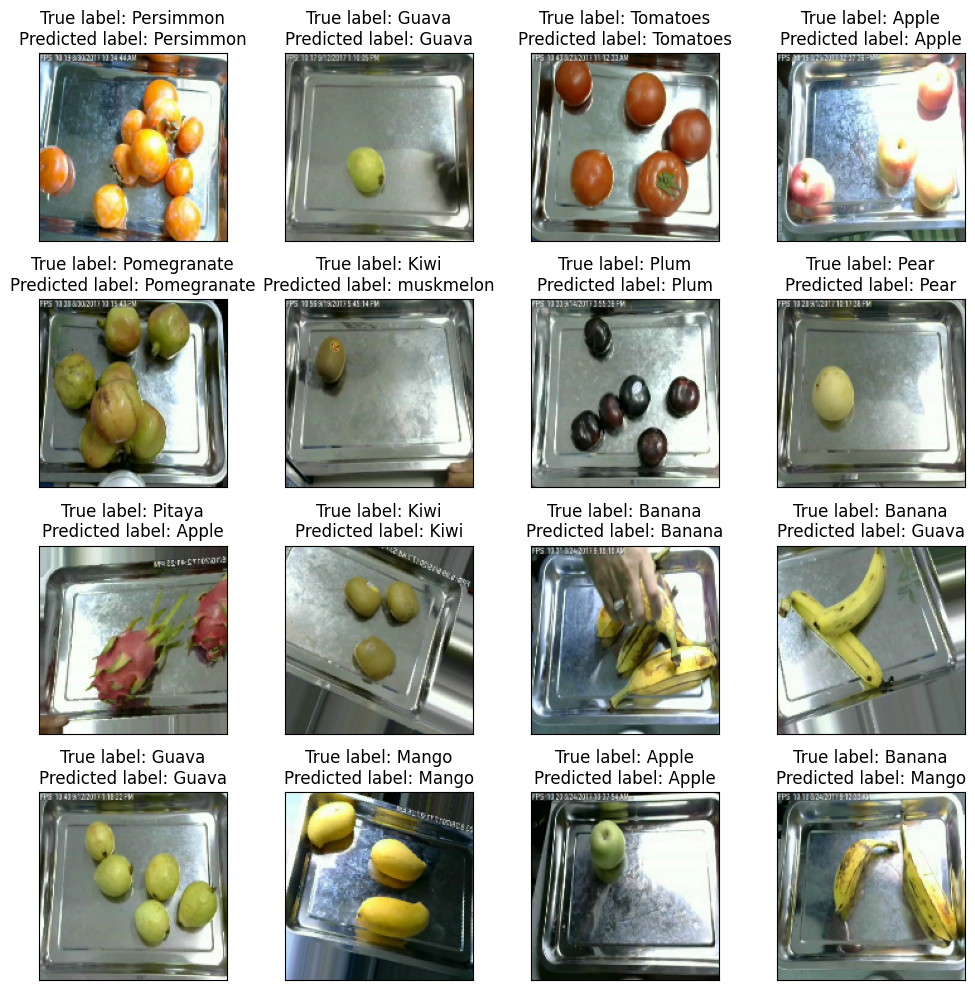

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X[-i])
    ax.set_title(f"True label: {fruit_names[y[-i]]}\nPredicted label: {fruit_names[pred[-i]]}")

plt.tight_layout()
plt.show()

In [20]:
# Use only 5% on the pictures to speed up the training
train_df,test_df = train_test_split(df[['path','fruit']].sample(frac=0.05,random_state=0), test_size=0.2,random_state=0)

In [21]:
import tensorflow as tf
from time import perf_counter

def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
#         rotation_range=30, # Uncomment those lines to use data augmentation
#         zoom_range=0.15,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.15,
#         horizontal_flip=True,
#         fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
#         rotation_range=30, # Uncomment those lines to use data augmentation
#         zoom_range=0.15,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.15,
#         horizontal_flip=True,
#         fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(15, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
#     "NASNetLarge": {"model":tf.keras.applications.NASNetLarge, "perf":0}, Deleted because the input shape has to be another one
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():

    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)

    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 2539 validated image filenames belonging to 15 classes.
Found 282 validated image filenames belonging to 15 classes.
Found 706 validated image filenames belonging to 15 classes.


29084464/29084464 [==============================] - 1s 0us/step
DenseNet121          trained in 40.24 sec
9406464/9406464 [==============================] - 1s 0us/step
MobileNetV2          trained in 22.63 sec
51877672/51877672 [==============================] - 2s 0us/step
DenseNet169          trained in 32.94 sec
74836368/74836368 [==============================] - 2s 0us/step
DenseNet201          trained in 36.86 sec
16705208/16705208 [==============================] - 1s 0us/step
EfficientNetB0       trained in 26.9 sec
27018416/27018416 [==============================] - 1s 0us/step
EfficientNetB1       trained in 29.73 sec
31790344/31790344 [==============================] - 1s 0us/step
EfficientNetB2       trained in 31.61 sec
43941136/43941136 [==============================] - 2s 0us/step
Eff

In [22]:
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.fruit)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
#     printmd(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

23/23 [==============================] - 6s 202ms/step


In [23]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

model  val_accuracy  accuracy  Training time (sec)
0         DenseNet201        0.9397    0.9533                36.86
1         DenseNet169        0.9184    0.9065                32.94
2         MobileNetV2        0.9043    0.8952                22.63
3           MobileNet        0.8972    0.8952                20.42
4         DenseNet121        0.8830    0.8881                40.24
5         ResNet152V2        0.8759    0.8810                37.16
6          ResNet50V2        0.8865    0.8612                44.65
7            Xception        0.8617    0.8569                32.70
8         ResNet101V2        0.8688    0.8456                31.78
9         InceptionV3        0.8085    0.8215                28.26
10  InceptionResNetV2        0.8191    0.8201                39.66
11       NASNetMobile        0.8404    0.8130                40.64
12              VGG19        0.5071    0.5212                26.13
13              VGG16        0.5319    0.5184                34.83
14   MobileNetV3Large        0.4007    0.3895                23.82
15          ResNet152        0.4184    0.3881                35.56
16           ResNet50        0.3972    0.3654                44.44
17     EfficientNetB2        0.3582    0.3499                31.61
18          ResNet101        0.3652    0.3385                33.07
19     EfficientNetB6        0.3262    0.3357                37.52
20     EfficientNetB4        0.3262    0.3329                39.83
21     EfficientNetB5        0.3156    0.3059                36.32
22     EfficientNetB7        0.3156    0.3031                36.61
23     EfficientNetB3        0.3050    0.2932                33.97
24   MobileNetV3Small        0.2695    0.2691                22.64
25     EfficientNetB1        0.2695    0.2691                29.73
26     EfficientNetB0        0.2695    0.2691                26.90

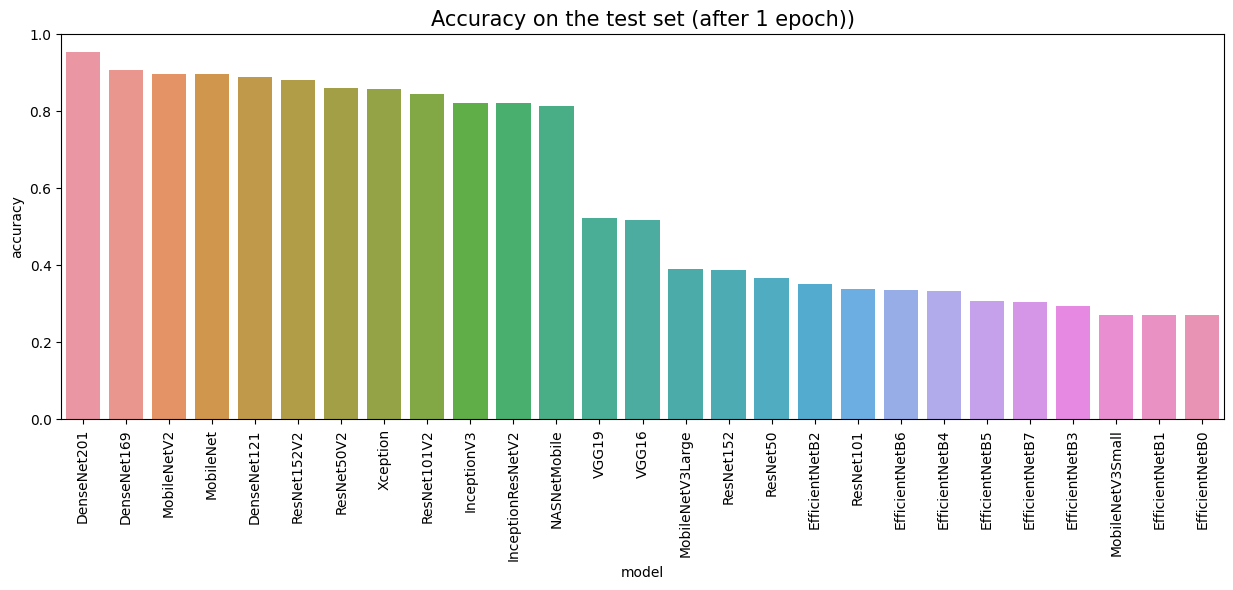

In [24]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

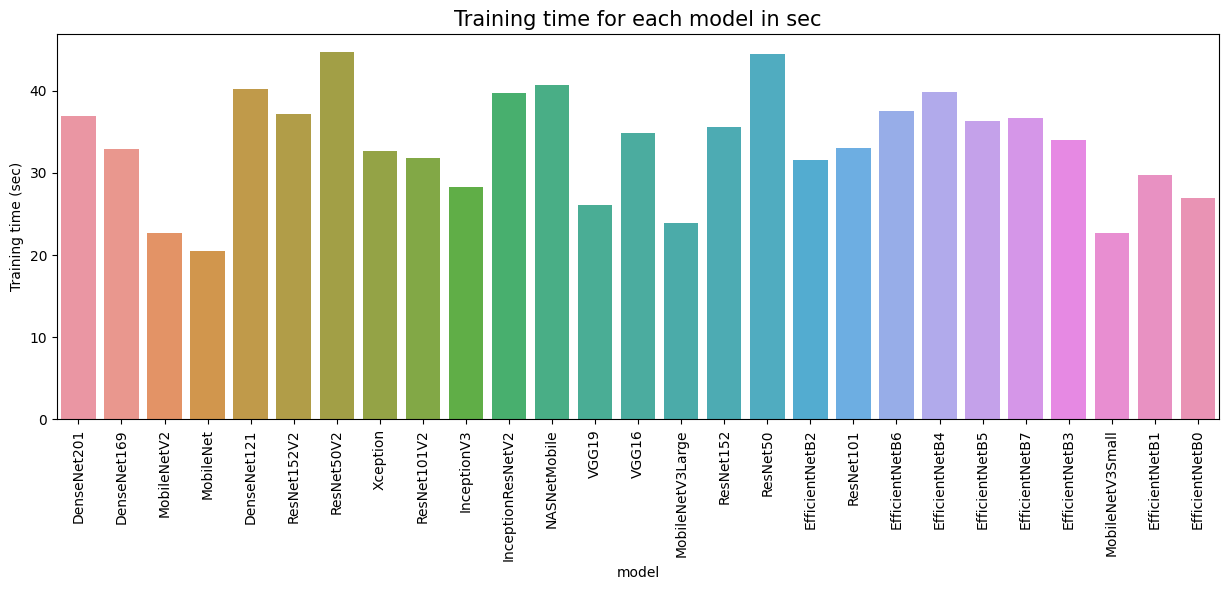

In [25]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Split into train/test datasets using all of the pictures
# train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)

# # Create the generator
# train_generator,test_generator,train_images,val_images,test_images=create_gen()

In [ ]:
# Create and train the model
# model = get_model(tf.keras.applications.DenseNet201)
# history = model.fit(train_images,
#                     validation_data=val_images,
#                     epochs=5,
#                     callbacks=[
#                         tf.keras.callbacks.EarlyStopping(
#                             monitor='val_loss',
#                             patience=1,
#                             restore_best_weights=True)]
#                     )

In [ ]:
# pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
# plt.title("Accuracy")
# plt.show()